In [1]:
import tensorflow as tf
import pandas as pd
import requests
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from src.kube.pod import get_pod_names
from src.prometheus.time_utils import generate_time
from src.prometheus.metrics import metric_labels
from src.prometheus.constants import prometheus_endpoint, prometheus_query, excluding_services

In [4]:
data_length = 420
offsets = [1598047832.6821344, 1598048432.9423163, 1598049032.9943507, 1598049633.0863874, 1598050233.1645138, 1598050833.2558558, 1598051433.366836, 1598052033.4203055, 1598052633.4842124, 1598053233.699553, 1598053833.741907, 1598054433.789637, 1598055033.8514934, 1598055634.24382, 1598056234.3267875, 1598056834.3907578, 1598057434.4455614, 1598058034.5075765, 1598058634.5720835, 1598059234.6254506, 1598059834.6723816, 1598060434.7206242, 1598061034.7685883, 1598061634.8055122, 1598062234.841223, 1598062834.9602003, 1598063435.252741, 1598064035.3158479, 1598064635.5269578, 1598065235.6270418, 1598065835.667722, 1598066435.7218814, 1598067035.7902415, 1598067635.8587837, 1598068236.2302053, 1598068836.2907255, 1598069436.3609302, 1598070036.4161923, 1598070636.4580853, 1598071236.493694, 1598071836.6565282, 1598072436.7347512] 
offsets_in_ms = [(((int(offset) - data_length + 1)), int(offset)) for offset in offsets]

In [22]:
pods = ['vehicles-service','customers-service', 'deliveries-service', 'orders-service',
        'availability-service', 'parcels-service']

In [6]:
files = glob.glob("/home/mfi/Pacco/Pacco.QoSNeuralNetwork/src/scrapped_data/not_scaled/*.csv")
files

['/home/mfi/Pacco/Pacco.QoSNeuralNetwork/src/scrapped_data/not_scaled/1598399688.csv']

In [7]:
datasets = [pd.read_csv(file) for file in files]
print(len(datasets))

1


In [7]:
dataset = [pd.read_csv(file) for file in files][0]


In [8]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(dataset)
dataset = pd.DataFrame(x_scaled, columns=dataset.columns)

In [31]:
dataset.shape

(420, 72)

In [10]:
batch_size = 420
datasets = np.array_split(dataset, dataset.shape[0] / batch_size)

In [11]:
from sklearn import linear_model
import random
import numpy as np

In [12]:
features_by_service = 9
prediction_column_idx_in_batch = -1

In [13]:
vehicle_service_index = pods.index('vehicles-service')
vehicle_service_index

0

In [330]:
train = datasets[7].iloc[:, [len(pods) * x for x in range(0, features_by_service)]]
test = datasets[23].iloc[:, [len(pods) * x for x in range(0, features_by_service)]]

trainX = train.iloc[:,:-1]
trainY = train.iloc[:,-1]

testX = test.iloc[:,:-1]
testY = test.iloc[:,-1]

In [96]:
train

,aspnetcore_requests_per_second_sum_vehicles-service,aspnetcore_requests_duration_seconds_vehicles-service,dotnet_gc_pause_ratio_vehicles-service,dotnet_threadpool_adjustments_total_vehicles-service,dotnet_threadpool_scheduled_total_vehicles-service,runtime_threadpool_threads_total_sum_vehicles-service,application_httprequests_error_rate_total_vehicles-service,application_httprequests_transactions_sum_vehicles-service,application_qos_violation_vehicles-service
0,0.000000,0.002665,0.000000,0.173910,0.006194,0.000000,0.000000,0.001031,0.0
1,0.000000,0.002665,0.000000,0.173904,0.003941,0.000000,0.000000,0.002711,0.0
2,0.000000,0.000878,0.000000,0.130430,0.009009,0.000000,0.007547,0.001927,0.0
3,0.000000,0.000878,0.012816,0.130430,0.025337,0.000000,0.007547,0.001875,0.0
4,0.000000,0.002645,0.014355,0.086955,0.032094,0.000000,0.015094,0.005476,0.0
...,...,...,...,...,...,...,...,...,...
415,0.264957,0.367510,0.350439,0.391272,0.525452,0.671875,0.588665,0.553717,0.0
416,0.264957,0.367510,0.314978,0.478233,0.332803,0.671875,0.573571,0.541512,0.0
417,0.256410,0.352239,0.339887,0.391349,0.106984,0.625000,0.505648,0.479769,0.0
418,0.368946,0.352239,0.239246,0.391349,0.014640,0.656250,0.471702,0.456869,0.0


In [14]:
import matplotlib.pyplot as plt

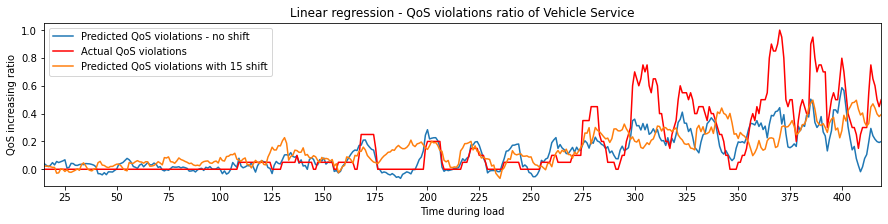

In [361]:
train = datasets[7].iloc[:, [len(pods) * x for x in range(0, features_by_service)]]
#test = datasets[random.randint(1, len(datasets))].iloc[:, [len(pods) * x for x in range(0, features_by_service)]]
test = datasets[23].iloc[:, [len(pods) * x for x in range(0, features_by_service)]]

trainX = train.iloc[:,:-1]
trainY = train.iloc[:,-1]

testX = test.iloc[:,:-1]
testY = test.iloc[:,-1]

shift =15

trainX_shifted = train.iloc[:-shift,:-1]
trainY_shifted = train.iloc[shift:,-1]

testX_shifted = test.iloc[:-shift,:-1]
testY_shifted = test.iloc[shift:,-1]

regr = linear_model.LinearRegression()
regr.fit(trainX, trainY)
prediction = regr.predict(testX)

regr.fit(trainX_shifted, trainY_shifted)
prediction_shited = regr.predict(testX_shifted)

x_ax = np.arange(shift, 420, 1, dtype=int)
plt.figure(figsize=(15,3))
plt.plot(x_ax, prediction[shift:])
plt.plot(x_ax, testY[shift:], color='red')
plt.plot(x_ax, prediction_shited)
plt.xlim([min(x_ax), max(x_ax)])
plt.xticks(np.arange(25, max(x_ax), 25, dtype=int))
plt.xlabel('Time during load')
plt.ylabel('QoS increasing ratio')
plt.title('Linear regression - QoS violations ratio of Vehicle Service')
plt.legend(['Predicted QoS violations - no shift', 'Actual QoS violations',
            f'Predicted QoS violations with {shift} shift'])
plt.savefig('plots/linear/1.png')

In [15]:
from scipy import signal, fftpack

In [16]:
train = dataset.iloc[:, [len(pods) * x for x in range(0, features_by_service)]]

In [45]:
train.corr()

,aspnetcore_requests_per_second_sum_vehicles-service,aspnetcore_requests_duration_seconds_vehicles-service,dotnet_gc_pause_ratio_vehicles-service,dotnet_threadpool_adjustments_total_vehicles-service,dotnet_threadpool_scheduled_total_vehicles-service,runtime_threadpool_threads_total_sum_vehicles-service,application_httprequests_error_rate_total_vehicles-service,application_httprequests_transactions_sum_vehicles-service,application_qos_violation_vehicles-service
aspnetcore_requests_per_second_sum_vehicles-service,1.000000,0.344296,0.237395,0.597801,0.646625,0.495437,0.284816,0.260950,0.380190
aspnetcore_requests_duration_seconds_vehicles-service,0.344296,1.000000,0.357633,0.372216,0.311143,0.559604,0.065317,0.800094,0.830743
dotnet_gc_pause_ratio_vehicles-service,0.237395,0.357633,1.000000,0.274783,0.281480,0.325319,0.052433,0.291384,0.396663
dotnet_threadpool_adjustments_total_vehicles-service,0.597801,0.372216,0.274783,1.000000,0.683131,0.464330,0.069190,0.294112,0.415981
dotnet_threadpool_scheduled_total_vehicles-service,0.646625,0.311143,0.281480,0.683131,1.000000,0.384145,0.062676,0.248513,0.352711
runtime_threadpool_threads_total_sum_vehicles-service,0.495437,0.559604,0.325319,0.464330,0.384145,1.000000,0.095032,0.455382,0.636316
application_httprequests_error_rate_total_vehicles-service,0.284816,0.065317,0.052433,0.069190,0.062676,0.095032,1.000000,0.022365,0.061399
application_httprequests_transactions_sum_vehicles-service,0.260950,0.800094,0.291384,0.294112,0.248513,0.455382,0.022365,1.000000,0.681662
application_qos_violation_vehicles-service,0.380190,0.830743,0.396663,0.415981,0.352711,0.636316,0.061399,0.681662,1.000000


In [24]:
def cross_corr(x, y, lag=0):
    return x.corr(y.shift(lag))


def shift_Factor(x, y, R):
    x_corr = [cross_corr(x, y, lag=i) for i in range(R)]

    # R factor is the number of the shifts who should be checked by the function
    Kot = pd.DataFrame(list(x_corr)).reset_index()
    Kot.rename(columns={0: 'Corr', 'index': 'Shift_num'}, inplace=True)

    # We find optimal correlation shift
    Kot['abs'] = Kot['Corr'].abs()
    SF = Kot.loc[Kot['abs'] == Kot['abs'].max(), 'Shift_num']
    p1 = SF.to_frame()
    SF = p1.Shift_num.max()
    
    return SF

In [25]:
R = 16
corrs_by_svc = {}

for dataset in datasets:
    for service in pods:
        service_index = pods.index(service)
        train = dataset.iloc[:, [(len(pods) * x) + service_index for x in range(0, features_by_service)]]
        for feature in range(0, features_by_service - 1):
            x = train.iloc[:,feature]
            y = train.iloc[:,prediction_column_idx_in_batch]
            SKO = shift_Factor(x,y,R)
            if service in corrs_by_svc:
                corrs_by_svc[service].append(SKO)
            else:
                corrs_by_svc[service] = [SKO]

In [26]:
# filter 0 and NaN values. There is no sense in shift lower than 2,when we put data into LSTM network in the future.
for corr in corrs_by_svc:
    corrs_by_svc[corr] = list(filter(lambda x: x > 3, corrs_by_svc[corr]))

In [27]:
def fancy_service_name(service):
    separated_names = service.split('-')
    for idx, _ in enumerate(separated_names):
        separated_names[idx] = separated_names[idx].capitalize()
    return ' '.join(separated_names)

/home/mfi/anaconda3/envs/TestTensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  This is separate from the ipykernel package so we can avoid doing imports until


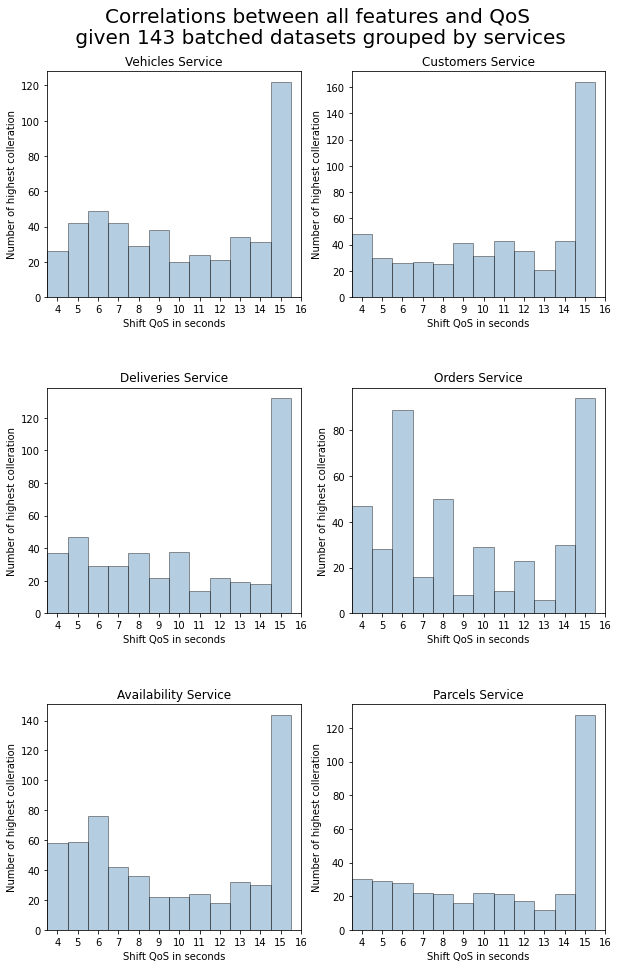

In [33]:
fig, axs = plt.subplots(3, 2, figsize=(10,15), gridspec_kw={'hspace': 0.4})
fig.suptitle(f'Correlations between all features and QoS\n given {int(60060 / batch_size)} batched datasets grouped by services', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
idx = [0, 0]
for service in corrs_by_svc:
    data = corrs_by_svc[service]
    
    
    if len(data) == 0:
        continue
    ax_data = axs[idx[0], idx[1]]
    bins = np.arange(4, 17)
    ax_data.hist(data, bins=bins, alpha=0.4, color='steelblue', edgecolor='black')
    ax_data.set_xlim([min(data), max(data)]) 
    
    bin_w = (max(bins) - min(bins)) / (len(bins))
    ax_data.set_xticks(bins + 0.5)
    ax_data.set_xticklabels(bins)
    
    ax_data.set_title(fancy_service_name(service))
    ax_data.set_xlabel("Shift QoS in seconds")
    ax_data.set_ylabel("Number of highest colleration")
    
    if idx[1] == 1:
        idx[1] = 0
        idx[0] = idx[0] + 1
    else:
        idx[1] = idx[1] + 1
        
plt.savefig('plots/correlations/1.png')